# Integration of ZarrDataset with Tensofrlow Datasets

In [1]:
import zarrdataset as zds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"
]

### Extracting patches of size 1024x1024 pixels from a Whole Slide Image (WSI)

Sample the image randomly

In [5]:
patch_size = dict(Y=768, X=1024)
patch_sampler = zds.BlueNoisePatchSampler(patch_size=patch_size)

Create a dataset from the list of filenames. All those files should be stored within their respective group "0".

Also, specify that the axes order in the image is Time-Channel-Depth-Height-Width (TCZYX), so the data can be handled correctly

In [6]:
my_dataset = zds.LabeledZarrDataset(filenames,
                                    data_group="3",
                                    source_axes="TCZYX",
                                    labels_filenames=[np.ones(1)],
                                    labels_source_axes="C",
                                    patch_sampler=patch_sampler,
                                    shuffle=True)

Create a Tensoflow Dataset from the ZarrDataset object

In [11]:
my_dataloader = tf.data.Dataset.from_generator(
            my_dataset.__iter__,
            output_signature=(tf.TensorSpec(shape=(1, 3, 1, None, None),
                                            dtype=tf.float32),
                              tf.TensorSpec(shape=(1,),
                                            dtype=tf.int64)))

batched_dataset = my_dataloader.batch(4)

This data loader can be used within Tensorflow training pipelines

In [19]:
samples = []
for i, (sample, target) in enumerate(my_dataloader):
    samples.append(np.moveaxis(sample[0, :, 0], 0, -1))

    print(f"Sample {i+1} with size {sample.shape}, and target {target}")

    if i > 5:
        # Take only five samples for illustration purposes
        break

samples_stack = np.hstack(samples)

Sample 1 with size (1, 3, 1, 768, 1024), and target [1]
Sample 2 with size (1, 3, 1, 768, 1024), and target [1]
Sample 3 with size (1, 3, 1, 768, 1024), and target [1]
Sample 4 with size (1, 3, 1, 768, 1024), and target [1]


In [21]:
samples_stack.shape

(768, 4096, 3)

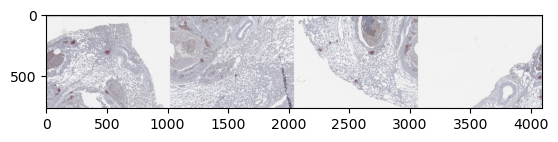

In [25]:
plt.imshow(samples_stack.astype(np.uint8))
plt.show()